In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#creates a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: #image center
        center = (int(w/2), int(h/2))
    if radius is None: #smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 40
noise = np.zeros((n, n), dtype='complex64')
noise.real = np.random.randn(n , n) / 10
noise.imag = np.random.randn(n , n) / 100

h, w = noise.shape
mask = circular_mask(h, w, radius=h/5)
sky_image = noise.copy()
sky_image[mask] = complex(np.random.rand() * 10, np.random.rand()  * 10)
print(sky_image)

[[-0.1548861 -0.00491901j  0.20519818-0.01973963j -0.02584393-0.0086267j
  ... -0.15232319-0.02446548j  0.14434458-0.01573127j
   0.09883605-0.00598212j]
 [ 0.08338872-0.00499991j  0.00035228+0.01800849j -0.00790717-0.02135031j
  ... -0.03388709+0.00165195j  0.05304031-0.01376015j
   0.14488049+0.00916079j]
 [ 0.19658028+0.02199532j  0.01076195-0.0130772j   0.02894591-0.00117568j
  ...  0.10850257+0.00082046j  0.01696492-0.00548659j
  -0.16207474-0.01263578j]
 ...
 [-0.08315134+0.00208137j  0.06243018-0.00390885j  0.11661685-0.00528849j
  ...  0.02309556-0.01159442j -0.11400308-0.00689359j
   0.02167949+0.00830954j]
 [-0.03914115-0.00257586j  0.02578168-0.00184754j -0.0309961 -0.00564857j
  ... -0.05063922-0.00018128j -0.10304342-0.00030313j
   0.13070862+0.00356159j]
 [-0.0800381 -0.0030082j   0.06582534+0.01730368j -0.03936101+0.0027853j
  ...  0.08995303-0.0140418j   0.1349098 +0.00119766j
   0.26952982-0.01277479j]]


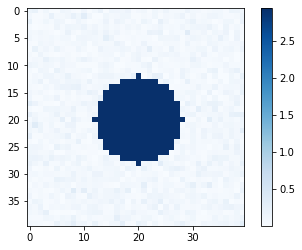

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar()

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 443.49255  +374.22504j   -357.67783  -308.29623j
   180.1052   +146.71187j   ...  -10.639337   -6.1095805j
   180.3685   +153.78123j   -357.95947  -305.221j    ]
 [-361.3614   -304.8535j     291.62656  +247.25568j
  -129.68427  -113.741684j  ...   -4.9209747 -11.241626j
  -129.95392  -108.06422j    288.10162  +251.31241j  ]
 [ 185.22386  +148.90857j   -130.74785  -116.35572j
    33.058     +26.189337j  ...   42.118423  +32.22948j
    27.54728   +29.356686j  -129.34361  -115.19272j  ]
 ...
 [  -6.0095215  -5.5038905j  -10.261117   -5.048467j
    37.365395  +36.62175j   ...  -53.278812  -44.219223j
    44.72448   +35.38841j     -9.578738   -7.650442j ]
 [ 184.74535  +151.24074j   -130.1353   -109.32515j
    27.832144  +28.942768j  ...   46.65563   +34.403828j
    32.363422  +32.710182j  -130.93143  -107.923096j ]
 [-361.54773  -308.6712j     288.37546  +242.75874j
  -129.58266  -116.44019j   ...   -4.8499837 -10.087514j
  -130.66527  -111.37448j    291.5222   +246.9657j   ]]


## 3) Source-finding classification

### Training labels

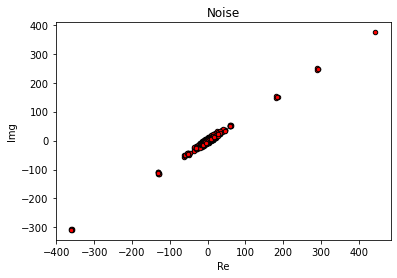

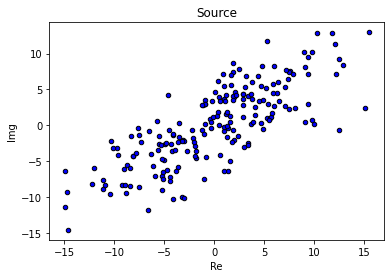

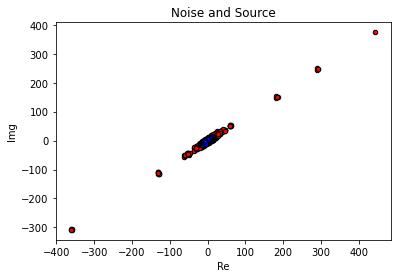

In [6]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [7]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [8]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [9]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 1e-3
epochs = 10
batch_size = 64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.263820 | Train accuracy: 0.629687 | Test Accuracy: 0.615625


20it [01:10,  3.52s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.268309 | Train accuracy: 0.628125 | Test accuracy: 0.618750


20it [01:09,  3.45s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.266376 | Train accuracy: 0.620313 | Test accuracy: 0.618750


20it [01:08,  3.42s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.264480 | Train accuracy: 0.621094 | Test accuracy: 0.628125


20it [01:12,  3.61s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.262620 | Train accuracy: 0.621094 | Test accuracy: 0.628125


20it [01:12,  3.61s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.260788 | Train accuracy: 0.621094 | Test accuracy: 0.628125


20it [01:12,  3.63s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.258977 | Train accuracy: 0.624219 | Test accuracy: 0.625000


20it [01:11,  3.59s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.257174 | Train accuracy: 0.623437 | Test accuracy: 0.621875


20it [01:11,  3.57s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.255368 | Train accuracy: 0.622656 | Test accuracy: 0.625000


20it [01:13,  3.69s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.253546 | Train accuracy: 0.623437 | Test accuracy: 0.625000


20it [01:11,  3.55s/it]


Epoch: 10 | Loss: 0.251693 | Train accuracy: 0.624219 | Test accuracy: 0.634375


### Results

Cost: 0.251693 | Train accuracy 0.624219 | Test Accuracy : 0.634375
Learned weights
Layer 0: [0.91606767 0.65505093 0.1310254 ]
Layer 1: [0.57649038 1.05739675 0.72478644]
Layer 2: [0.68181412 0.43833917 0.98352421]


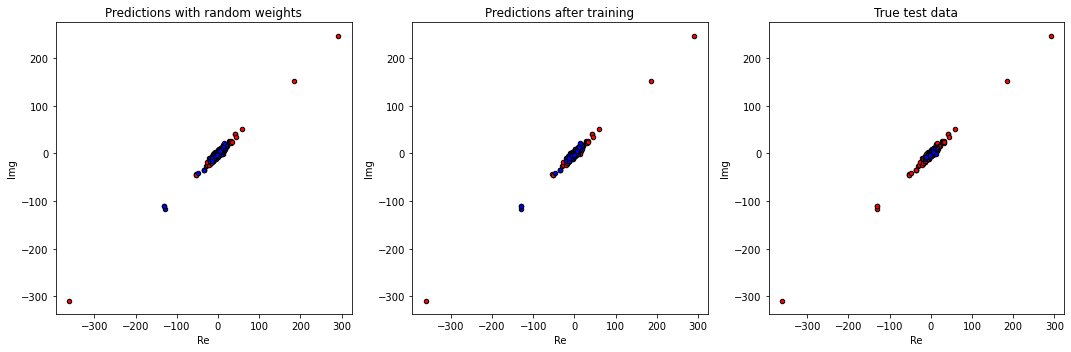

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1
 -1  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  1  0  0  0
  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0]


In [11]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()

print(predicted_test - initial_predictions)